In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import matplotlib.animation as graphics
from matplotlib import rc
from IPython.display import HTML

In [3]:
# part 1

In [4]:
file_path = r'/content/drive/MyDrive/Medical Image/Neuro3'
os.chdir(file_path)

In [5]:
def print_image(image):
    plt.imshow(image, 'gray')
    plt.show()

In [6]:
def open_file(file_path):
    file = open(file_path, 'r')
    return file

In [7]:
def txt_to_array(file):
    image = []
    lines = file.readlines()
    for i in lines:
        line = i[:-1]
        intensities = list(map(float, line.split(',')))
        for j in range(len(intensities)):
            if intensities[j]>0:
                intensities[j]=1
            else:
                intensities[j]=-1
        image.append(intensities)
    image = np.array(image)
    return image

In [8]:
def visualize(image_files):
    fig, ax = plt.subplots(1, len(image_files), sharex=True, sharey=True, figsize=(15,7))
    for i in range(len(ax)):
        file = open_file(image_files[i])
        image = txt_to_array(file)
        ax[i].imshow(image, 'gray')
    plt.show()

['/content/drive/MyDrive/Medical Image/Neuro3/ball.txt', '/content/drive/MyDrive/Medical Image/Neuro3/cat.txt', '/content/drive/MyDrive/Medical Image/Neuro3/mona.txt']


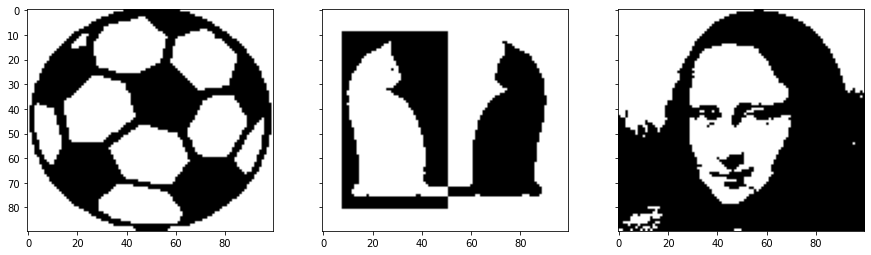

In [9]:
image_txt_files = []
for file in glob.glob("*.txt"):
    image_txt_files.append(file)
image_files = []
for i in image_txt_files:
    image_files.append(os.path.join(file_path, i))
print(image_files)
visualize(image_files)

In [10]:
class hopfield_network:
    def __init__(self, S, neurons=90*100, dt=0.01, lamda=10):
        self.pattern = S.flatten()
        #print(self.pattern)
        self.weights = np.outer(self.pattern, self.pattern)/neurons
        #print(self.weights.shape)
        self.neurons = np.zeros(neurons)
        self.dt = dt
        self.lamda = lamda
        self.rmse = float('inf')
        
    def set_trigger_cue(self, cue):
        self.neurons = cue.flatten()
        
    def take_a_step(self):
        #print(self.weights.shape, self.neurons.T.shape)
        du = ((-1*self.neurons) + self.weights@(np.tanh(self.lamda*self.neurons).T)) * self.dt
        u = self.neurons + du
        self.neurons = u
            
    def cal_rmse(self):
        self.rmse = np.sqrt(((self.neurons - self.pattern) ** 2).mean())

In [11]:
# part 2

In [12]:
ball_path = r'/content/drive/MyDrive/Medical Image/Neuro3/ball.txt'
file = open_file(ball_path)
image = txt_to_array(file)

In [13]:
# initialize a hopfield network and store an image
network = hopfield_network(image, neurons=9000, dt=0.01, lamda=10)

In [14]:
# prepare cue
def create_cue(image, size=30):
    cue = np.zeros(image.shape)
    random.seed(size)
    starti = random.randint(0, image.shape[0]-size-1)
    startj = random.randint(0, image.shape[1]-size-1)
    for i in range(starti, starti+size):
        for j in range(startj, startj+size):
            cue[i][j] = image[i][j]
    return cue

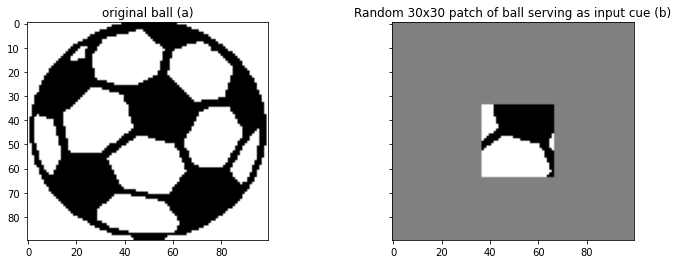

In [15]:
cue = create_cue(image, size=30)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))
ax[0].imshow(image, 'gray')
ax[0].title.set_text("original ball (a)")
ax[1].imshow(cue, 'gray')
ax[1].title.set_text("Random 30x30 patch of ball serving as input cue (b)")
plt.show()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


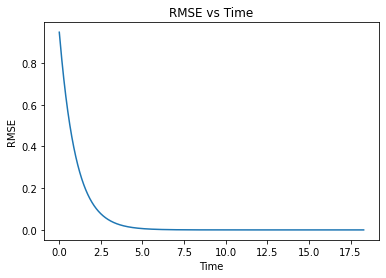

In [16]:
%time
network = hopfield_network(image, neurons=9000, dt=0.01, lamda=1000)
network.set_trigger_cue(cue)
flag = True
rmse = []
time = []
t=0
while(flag):
    network.take_a_step()
    t=t+0.01
    network.cal_rmse()
    error = network.rmse
    rmse.append(error)
    time.append(t)
    if error<1e-8:
        break
plt.plot(time, rmse)
plt.title('RMSE vs Time')
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.show()

In [17]:
rmse[-1]

9.971645754855464e-09

In [18]:
# part 3

In [19]:
class multi_memory_hopfield_network:
    def __init__(self, cat,mona,ball, neurons=90*100, dt=0.01, lamda=10):
        self.cat = cat.flatten()
        self.mona = mona.flatten()
        self.ball = ball.flatten()
        self.weights = (np.outer(cat.flatten(), cat.flatten()) + np.outer(mona.flatten(), mona.flatten()) + np.outer(ball.flatten(), ball.flatten()))/neurons
        self.neurons = np.zeros(neurons)
        self.dt = dt
        self.lamda = lamda
        self.rmse = float('inf')
        
    def set_trigger_cue(self, cue):
        self.neurons = cue.flatten()
    
    def assign_zero_weights(self, x):
        if x!=0:
            rows = np.random.randint(0,9000, int(x*0.01*9000*9000))
            columns = np.random.randint(0,9000, int(x*0.01*9000*9000))
            for i in range(len(rows)):
                self.weights[rows[i],columns[i]]=0

    def take_a_step(self):
        du = ((-1*self.neurons) + self.weights@(np.tanh(self.lamda*self.neurons).T)) * self.dt
        u = self.neurons + du
        self.neurons = u
        
    def cal_rmse(self, target):
        if target == 'cat':
            self.rmse = np.sqrt(((self.neurons - self.cat) ** 2).mean())
        elif target == 'mona':
            self.rmse = np.sqrt(((self.neurons - self.mona) ** 2).mean())
        else:
            self.rmse = np.sqrt(((self.neurons - self.ball) ** 2).mean())
            
    def get_current_output(self):
        return self.neurons.reshape((90,100))

In [24]:
def animate_output(cat,mona,ball, cue, name, ax,x=0):
    network = multi_memory_hopfield_network(cat,mona,ball, neurons=9000, dt=0.01, lamda=1000)
    network.set_trigger_cue(cue)
    network.assign_zero_weights(x)
    flag = True
    rmse = []
    time = []
    output_list = []
    t=0
    i=0
    while(flag):
        prev = network.neurons
        network.take_a_step()
        now = network.neurons
        i=i+1
        t=t+0.01
        network.cal_rmse(name)
        error = network.rmse
        rmse.append(error)
        time.append(t)
        image = network.get_current_output()
        plot = ax.imshow(image, 'gray', animated=True, interpolation='none', vmin=-1, vmax=1)
        title = plt.text(0.5,1.05,"iteration = {}".format(i), size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes )
        output_list.append([plot, title])
        if i==700:
            break
        if np.array_equal(prev, now):
            break
        if error<1e-8:
            break
    return rmse, time, image, output_list

In [25]:
images = []
for i in image_files:
    file = open_file(i)
    image = txt_to_array(file)
    images.append(image)
images = np.array(images)

In [26]:
def demo(images, index, name, x=0):
  fig, ax=plt.subplots()
  rmse, time, image, output_list = animate_output(images[1],images[2],images[0], create_cue(images[index], 30), name, ax,x)
  animator = graphics.ArtistAnimation(fig, output_list, interval = 200, blit=True, repeat_delay=1000)
  rc('animation', html='html5')
  display(animator)
  writer = graphics.FFMpegWriter(fps=5, metadata=dict(artist='Chella'), bitrate=1800)
  animator.save(str(x)+'% '+name+'.mp4', writer=writer)
  fig, ax = plt.subplots(1, 3, figsize=(16,4))
  ax[0].imshow(image, 'gray', interpolation='none', vmin=-1, vmax=1)
  ax[0].set_title('final recovered image')
  ax[1].imshow(create_cue(images[index], 30), 'gray')
  ax[1].title.set_text('Initial Cue')
  ax[2].plot(time, rmse)
  ax[2].set_ylim((-0.05,1))
  ax[2].set_title('RMSE vs Time')
  ax[2].set_xlabel('Time')
  ax[2].set_ylabel('RMSE')
  plt.show()

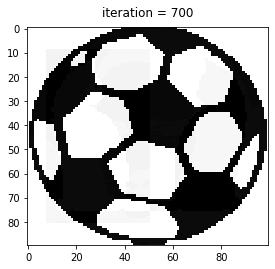

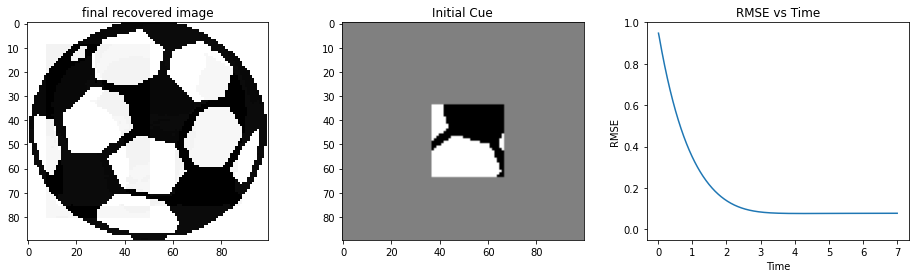

In [27]:
demo(images, 0, 'ball', 0)

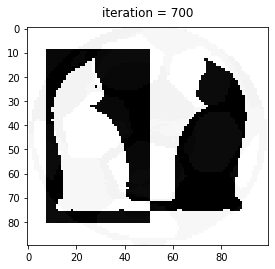

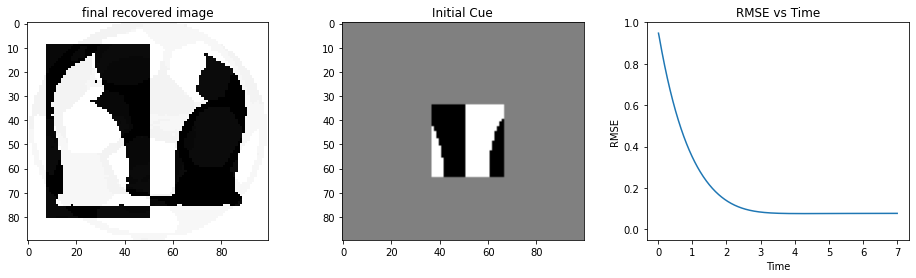

In [28]:
demo(images, 1, 'cat', 0)

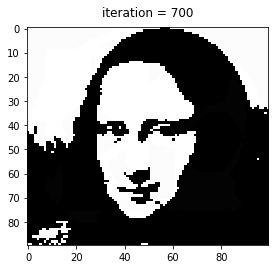

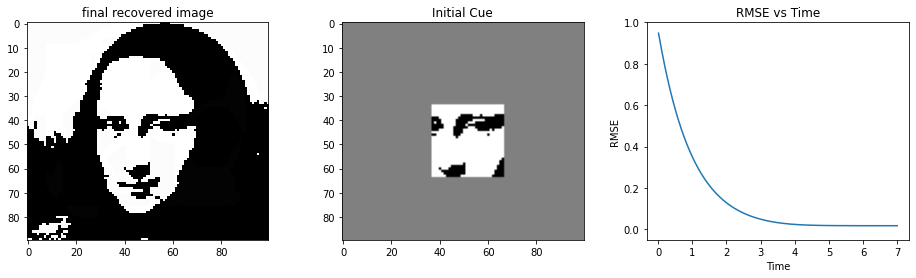

In [29]:
demo(images, 2, 'mona', 0)

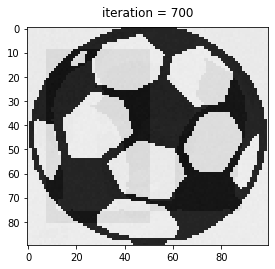

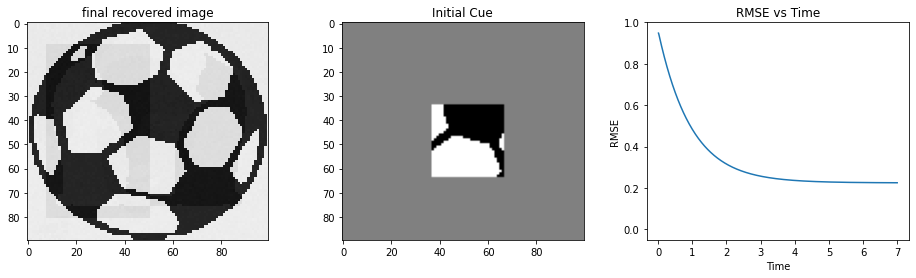

In [30]:
demo(images, 0, 'ball', 25)

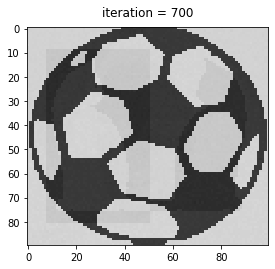

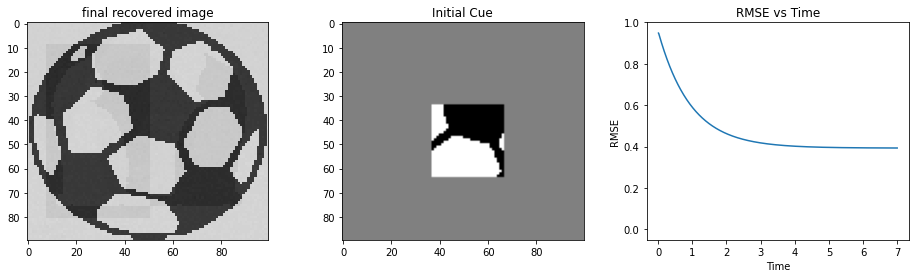

In [31]:
demo(images, 0, 'ball', 50)

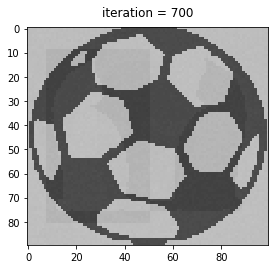

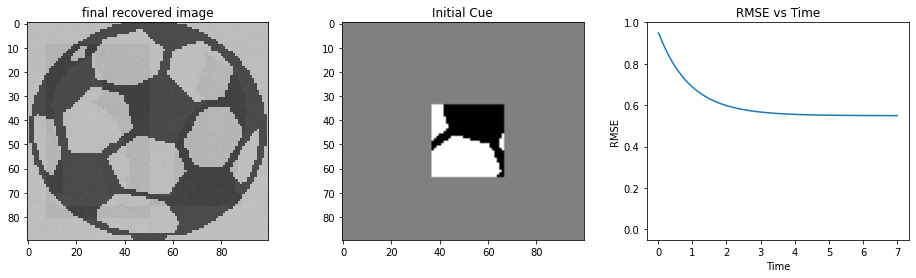

In [32]:
demo(images, 0, 'ball', 80)

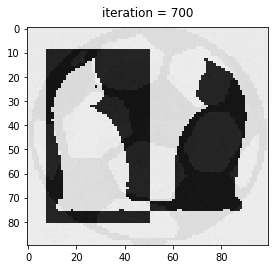

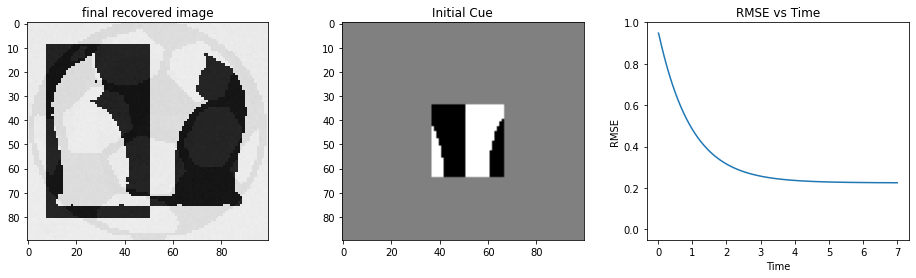

In [33]:
demo(images, 1, 'cat', 25)

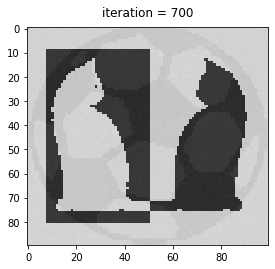

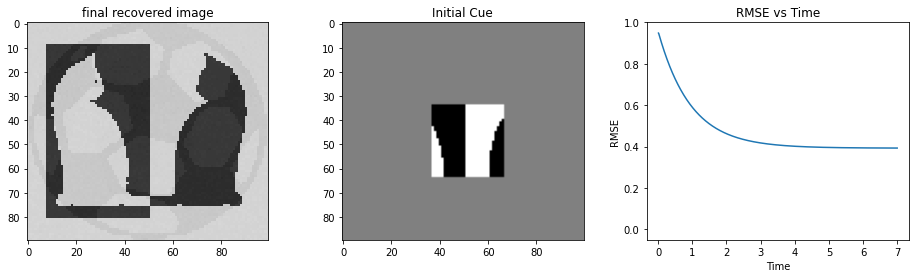

In [34]:
demo(images, 1, 'cat', 50)

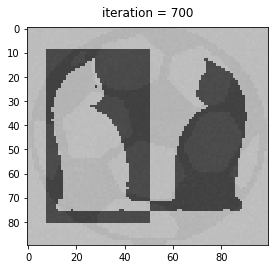

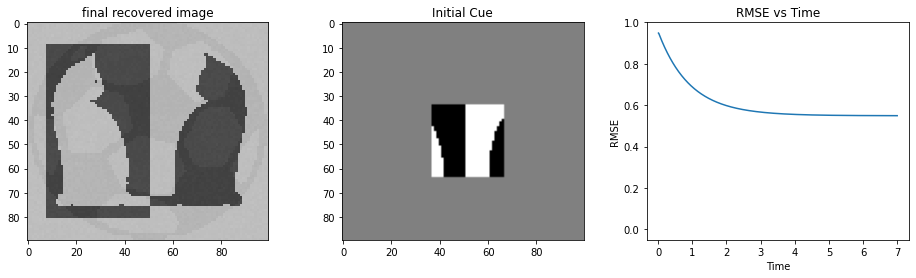

In [35]:
demo(images, 1, 'cat', 80)

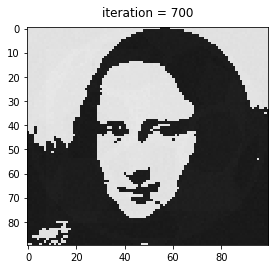

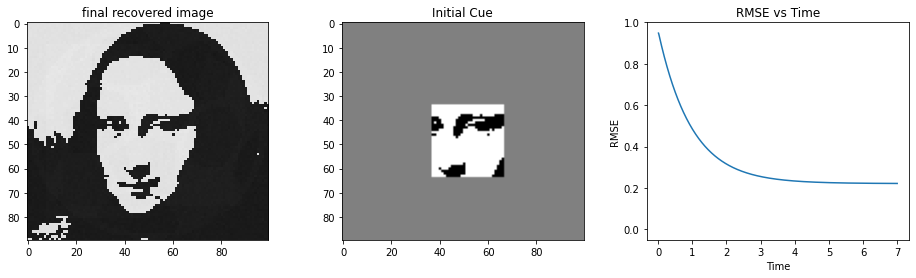

In [36]:
demo(images, 2, 'mona', 25)

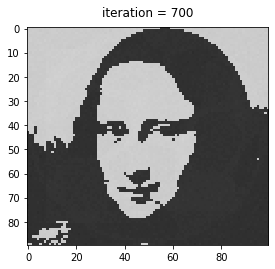

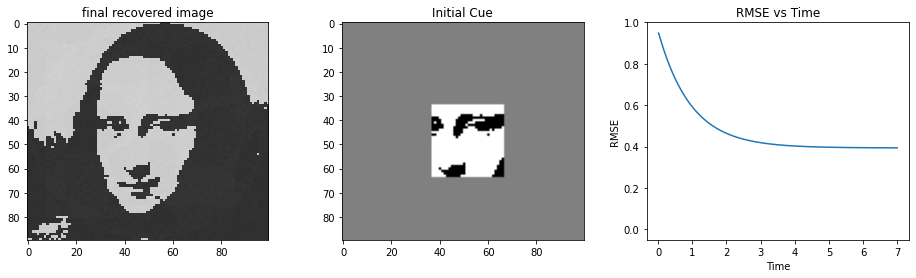

In [37]:
demo(images, 2, 'mona', 50)

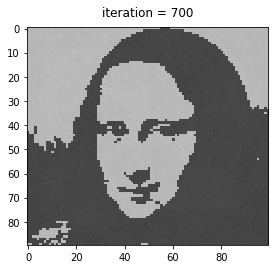

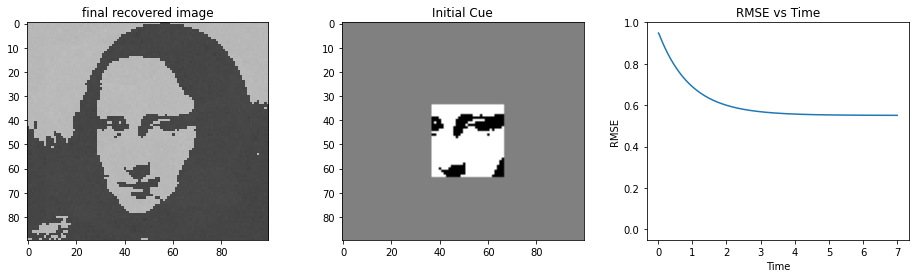

In [38]:
demo(images, 2, 'mona', 80)